# Volume 3: Gibbs Sampling and LDA
    Kaela Nelson
    Vol3B
    2/1/1996

Lab Objective: Understand the basic principles of implementing a Gibbs sample. Apply this to Latent Dirchlet Allocation. The source for this lab is given at: http://www.acme.byu.edu/wp-content/uploads/2018/02/GibbsLDA.pdf .

Gibbs Sampling is a Markov Chain Monte Carlo (MCMC) sampling method. We construct a Markov chain to sample from a desired joint distribution,
$P(x_1,...,x_n|y).$ Note that it is easier to sample from the one dimensional conditional distributions, $P(x_i|x_{-i},y)$ where $x_{-i} = x_i, ..., x_{i-1}, x_{i+1}, ..., x_n.$ 

In [2]:
import numpy as np
from scipy.special import gammaln
from scipy.stats import norm
from math import sqrt
from scipy.stats import invgamma
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde

from tqdm import tqdm_notebook

## Problem 1

Implement a Gibbs sampler for the exam scores problem (using the data in `examscores.npy`). Note that we assume the spread of these exam scores can be modeled with a normal distribution of mean $\mu$ and variance $\sigma^2.$ 

In [3]:
def gibbs(y, nu, tau2, alpha, beta, n_samples):
    """Gibbs sampler for the exam scores problem, assuming the
    following likelihood and priors.

        y_i    ~ N(mu, sigma2),
        mu     ~ N(nu, tau2),
        sigma2 ~ IG(alpha, beta),

    Parameters:
        y ((N,) ndarray): the exam scores.
        nu (float): The prior mean parameter for mu.
        tau2 (float > 0): The prior variance parameter for mu.
        alpha (float > 0): The prior alpha parameter for sigma2.
        beta (float < 0): The prior beta parameter for sigma2.
        n_samples (int): the number of samples to draw.

    Returns:
        ((n_samples, 2) ndarray): The mu and sigma2 samples (as columns).
    """
    sigma2_samples = []
    sigma2 = np.var(y)
    
    mu_samples = []
    mu = np.average(y)
    
    for k in range(n_samples):
        # updates tau2, nu, alpha, and beta
        new_tau2 = 1./((1./tau2) + (len(y)/float(sigma2)))
        new_nu = (new_tau2)*((nu/float(tau2)) + (1./float(sigma2))*(sum(y)))
        new_alpha = alpha + len(y)/2.
        new_beta = beta + .5*sum([(i - mu)**2 for i in y])

        # uses new parameters to draw from normal and inv gamma distribution
        mu = norm.rvs(new_nu, scale=sqrt(new_tau2))
        mu_samples.append(mu)
        
        sigma2 = invgamma.rvs(new_alpha, scale=new_beta)
        sigma2_samples.append(sigma2)

    return mu_samples, sigma2_samples

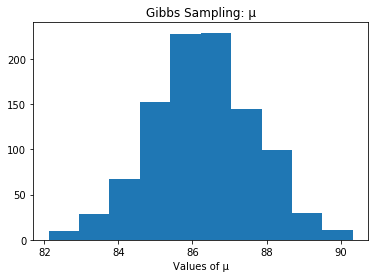

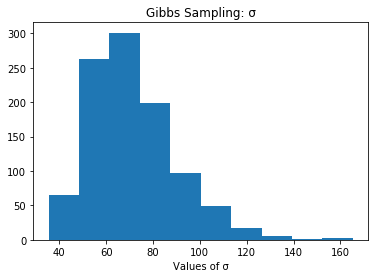

In [4]:
# initial parameters
mu = 0. 
sigma2 = 9. 
normal_sample = norm.rvs(mu, scale=sqrt(sigma2))
alpha = 3.
beta = 50.
n_samples = 1000
nu = 80
tau2 = 16
invgamma_sample = invgamma.rvs(alpha, scale=beta)

# load data
y = np.load("examscores.npy")

# runs gibbs sampling method
mu, sigma2 = gibbs(y, nu, tau2, alpha, beta, n_samples)

plt.hist(mu)
plt.title("Gibbs Sampling: μ")
plt.xlabel("Values of μ")
plt.show()

plt.hist(sigma2)
plt.title("Gibbs Sampling: σ")
plt.xlabel("Values of σ")
plt.show()

## Problem 2

Plot the kernel density estimators for the posterior distributions of $\mu$ and $\sigma^2$.

Next, use your samples of $\mu$ and $\sigma^2$ to draw samples from the posterior predictive distribution.
Plot the kernel density estimator of your sampled scores.

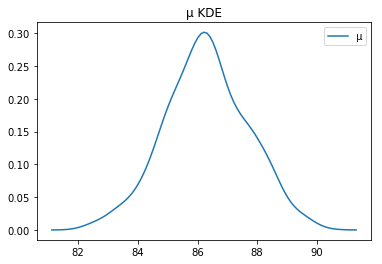

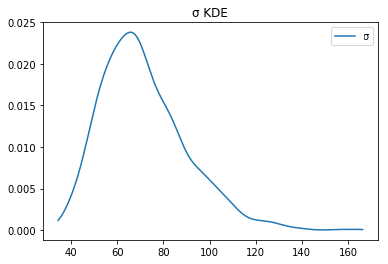

In [6]:
# kde for mu
mu_kernel = gaussian_kde(mu)
x_min = min(mu) - 1
x_max = max(mu) + 1
x = np.arange(x_min, x_max, step=0.1)
plt.plot(x,mu_kernel(x), label="μ")
plt.legend()
plt.title("μ KDE")
plt.show()

# kde for sigma2
s2_kernel = gaussian_kde(sigma2)
x_min = min(sigma2) - 1
x_max = max(sigma2) + 1
x = np.arange(x_min, x_max, step=0.1)
plt.plot(x,s2_kernel(x), label = "σ")
plt.legend()
plt.title("σ KDE")
plt.show()

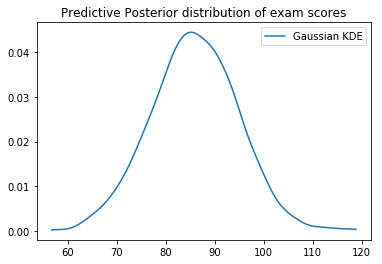

In [8]:
y = []
for i in range(len(mu)):
    #sample from normal distribution
    y.append(np.random.normal(mu[i], np.sqrt(sigma2[i])))
    
y_kernel = gaussian_kde(y)
x_min = min(y) - 1
x_max = max(y) + 1
x = np.arange(x_min, x_max, step=0.1)
plt.plot(x,y_kernel(x), label = "Gaussian KDE")
plt.title("Predictive Posterior distribution of exam scores")
plt.legend()
plt.show()

## Problem 3

Implement `LDACGS.initialize()`.
By randomly assigning initial topics, fill in the count matrices and topic assignment dictionary.
In this method, you will initialize the count matrices (among other things).

To be explicit, you will need to initialize $nmz$, $nzw$, and $nz$ to be zero arrays of the correct size.
Then, in the second for loop, you will assign z to be a random integer in the correct range of topics.
In the increment step, you need to figure out the correct indices to increment by one for each of the three arrays.
Finally, assign $topics$ as given.

## Problem 4

Complete `LDACGS._sweep()`, which needs to iterate through each word of each document.
It should call `LDACGS._conditional()` to get the conditional distribution at each iteration.

Note that the first part of this method will undo what `LDACGS.initialize()` did.
Then we will use the conditional distribution (instead of the uniform distribution we used previously) to pick a more accurate topic assignment.
Finally, the latter part repeats what we did in `LDACGS.initialize()`, but does so using this more accurate topic assignment.

## Problem 5

Complete `LDACGS.sample()`.
The argument `filename` is the name and location of a .txt file, where each line is considered a document.
The corpus is built by `LDACGS.buildCorpus()`, and stopwords are removed (if argument `stopwords` is provided).
Burn in the Gibbs sampler, computing and saving the log-likelihood with the method `_loglikelihood()`.
After the burn in, iterate further, accumulating your count matrices, by adding `nzw` and `nmz` to `total_nzw` and `total_nmz` respectively, where you only add every `sample_rate`th iteration. 
Also save each log-likelihood.

In [9]:
class LDACGS:
    """Do LDA with Gibbs Sampling."""

    def __init__(self, n_topics, alpha=0.1, beta=0.1):
        """Initialize system parameters."""
        self.n_topics = n_topics
        self.alpha = alpha
        self.beta = beta

    def buildCorpus(self, filename, stopwords_file=None):
        """Read the given filename and build the vocabulary."""
        
        # read in document
        with open(filename, 'r') as infile:
            doclines = [line.rstrip().lower().split(' ') for line in infile]
            
        n_docs = len(doclines)
        self.vocab = list({v for doc in doclines for v in doc})
        
        if stopwords_file:
            with open(stopwords_file, 'r') as stopfile:
                stops = stopfile.read().split()
            self.vocab = [x for x in self.vocab if x not in stops]
            self.vocab.sort()
            
        self.documents = []
        for i in range(n_docs):
            self.documents.append({})
            for j in range(len(doclines[i])):
                if doclines[i][j] in self.vocab:
                    self.documents[i][j] = self.vocab.index(doclines[i][j])

    def initialize(self):
        """Initialize the three count matrices."""
        self.n_words = len(self.vocab)
        self.n_docs = len(self.documents)
        
        # Initialize the three count matrices.
        # The (m,z) entry of self.nmz is the number of words in document m assigned to topic z.
        self.nmz = np.zeros((self.n_docs, self.n_topics))
        
        # The (z,i) entry of self.nzw is the number of times term i is assigned to topic z.
        self.nzw = np.zeros((self.n_topics, self.n_words))
        
        # The (z)-th entry is the number of times topic z is assigned in the corpus.
        self.nz = np.zeros(self.n_topics)

        # Initialize the topic assignment dictionary.
        self.topics = {} # key-value pairs of form (m,i):z

        for m in range(self.n_docs):
            for i in self.documents[m]:
                # Get random topic assignment, i.e. z = ...
                z = np.random.randint(self.n_topics)
                
                # Increment count matrices
                self.nmz[m,z] += 1
                w = self.documents[m][i]
                self.nzw[z, w] += 1
                self.nz[z] += 1
                
                # Store topic assignment, i.e. self.topics[(m,i)]=z
                self.topics[(m,i)]=z

    def sample(self,filename, burnin=100, sample_rate=10, n_samples=10, stopwords_file=None):
        self.buildCorpus(filename, stopwords_file)
        self.initialize()
        self.total_nzw = np.zeros((self.n_topics, self.n_words))
        self.total_nmz = np.zeros((self.n_docs, self.n_topics))
        self.logprobs = np.zeros(burnin + sample_rate*n_samples)
        
        for i in tqdm_notebook(range(burnin)):
            # Sweep and store log likelihood.
            self._sweep()
            self.logprobs[i] = self._loglikelihood()
                        
        for i in tqdm_notebook(range(n_samples*sample_rate)):
            # Sweep and store log likelihood
            self._sweep()
            self.logprobs[burnin + i] = self._loglikelihood()

            if not i % sample_rate:
                # accumulate counts
                self.total_nzw += self.nzw
                self.total_nmz += self.nmz
                
    def phi(self):
        phi = self.total_nzw + self.beta
        self._phi = phi / np.sum(phi, axis=1)[:,np.newaxis]

    def theta(self):
        theta = self.total_nmz + self.alpha
        self._theta = theta / np.sum(theta, axis=1)[:,np.newaxis]

    def topterms(self,n_terms=10):
        self.phi()
        self.theta()
        vec = np.atleast_2d(np.arange(0,self.n_words))
        topics = []
        for k in range(self.n_topics):
            probs = np.atleast_2d(self._phi[k,:])
            mat = np.append(probs,vec,0)
            sind = np.array([mat[:,i] for i in np.argsort(mat[0])]).T
            topics.append([self.vocab[int(sind[1,self.n_words - 1 - i])] for i in range(n_terms)])
        return topics

    def toplines(self,n_lines=5):
        lines = np.zeros((self.n_topics,n_lines))
        for i in range(self.n_topics):
            args = np.argsort(self._theta[:,i]).tolist()
            args.reverse()
            lines[i,:] = np.array(args)[0:n_lines] + 1
        return lines

    def _removeStopwords(self, stopwords):
        return [x for x in self.vocab if x not in stopwords]

    def _conditional(self, m, w):
        dist = (self.nmz[m,:] + self.alpha) * (self.nzw[:,w] + self.beta) / (self.nz + self.beta*self.n_words)
        return dist / np.sum(dist)

    def _sweep(self):
        for m in range(self.n_docs):
            for i in self.documents[m]:             
                # Retrieve topic assignment for i-th word in document m.
                topic = self.topics[(m,i)]
                
                # Decrement count matrices.
                self.nmz[m,topic] -= 1
                w = self.documents[m][i]
                self.nzw[topic, w] -= 1
                self.nz[topic] -= 1
                
                # Get conditional distribution.
                cond_dist = self._conditional(m, w)
                
                # Sample new topic assignment.
                new_topic = np.random.choice(np.arange(self.n_topics), None, p=cond_dist)
                
                # Increment count matrices.
                self.nmz[m,new_topic] += 1
                self.nzw[new_topic, w] += 1
                self.nz[new_topic] += 1
                
                # Store new topic assignment.
                self.topics[(m,i)] = new_topic
                

    def _loglikelihood(self):
        lik = 0

        for z in range(self.n_topics):
            lik += np.sum(gammaln(self.nzw[z,:] + self.beta)) - gammaln(np.sum(self.nzw[z,:] + self.beta))
            lik -= self.n_words * gammaln(self.beta) - gammaln(self.n_words*self.beta)

        for m in range(self.n_docs):
            lik += np.sum(gammaln(self.nmz[m,:] + self.alpha)) - gammaln(np.sum(self.nmz[m,:] + self.alpha))
            lik -= self.n_topics * gammaln(self.alpha) - gammaln(self.n_topics*self.alpha)

        return lik



## Problem 6

Create an `LDACGS` object with $20$ topics, letting $\alpha$ and $\beta$ be the default values.
Run the Gibbs sampler, with a burn in of $100$ iterations, accumulating $10$ samples, only keeping the results of every $10$th sweep.
Use `stopwords.txt` as the stopwords file.

Plot the log-likelihoods. How long did it take to burn in?

In [10]:
L = LDACGS(20)
L.sample(filename="reagan.txt", stopwords_file="stopwords.txt")

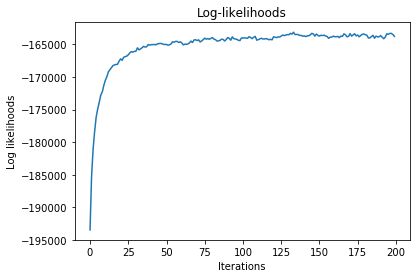

In [4]:
plt.plot(np.arange(200), L.logprobs, label="Log likelihood")
plt.title("Log-likelihoods")
plt.xlabel("Iterations")
plt.legend()
plt.show()

Based on observation, the burnin took about 20 iterations.

## Problem 7

Using `topterms()` to examine the topics for Reagan's addresses.
Come up with labels for each topic.
If `ntopics=20` and `n=10`, we will get the top $10$ words that represent each of the $20$ topics; for each topic, decide what these ten words jointly represent.

In [5]:
# topics = L.topterms()
for l in L.topterms():
    print(l)

['space', 'develop', 'research', 'build', 'enterprise', "we're", 'technology', 'industry', 'save', 'well,']
['freedom', 'people', 'peace', 'democratic', 'free', 'world', 'central', 'america', 'democracy', 'great']
['mr.', 'members', 'congress,', 'speaker,', 'bipartisan', 'president,', 'senate', 'distinguished', 'fellow', 'house']
['children', 'families', 'education', 'school', 'back', 'commitment', 'and,', 'encourage', 'parents', 'give']
["it's", "we're", 'time', "i've", "there's", 'america', 'now,', 'past', 'well,', 'century']
['federal', 'government', 'budget', 'states', "let's", 'programs', 'local', 'people', 'american', 'time']
['america', '--', 'life', 'spirit', 'make', 'tonight,', 'children', 'work', 'us,', 'american']
['economic', 'spending', 'tax', 'federal', 'billion', 'government', 'program', 'inflation', 'interest', 'rates']
['congress', 'state', 'president', 'union', 'address', 'joint', 'administration', 'session', 'ronald', "reagan's"]
['programs', 'people', 'special', 'wa

For each of the topics, here is a phrase that represents the joint representation from top to bottom in the lists above:

-Advancing in technology

-the American Dream

-Government

-Ideal family standards

-America in the past

-Programs created by the government in America

-American spirit

-Economic well being

-policies under Reagan's presidency

-America's food stamp system

-America's trading system

-America is futuristic

-America is a free country and a united nation

-Employment/unemployment

-America's media industry

-"I'll make America great again"- Trump

-Poverty in america

-American defense system

-"God bless America"

-Laws against crime
